In [1]:
import urllib
import urllib.request
import json
import pandas as pd
import numpy as np
import os

# Visualization
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Import Data

In [2]:
# Base directory path
base_dir = '/Users/tytatee/Library/CloudStorage/GoogleDrive-possakorn.k@gmail.com/My Drive/00_script/c_github/personal_project:_adelaide_metrocard_validation/'

# Corrected resources list with the appropriate filenames
resources_list = {
	'2024_q2': 'bandedvalidations2024-02.csv',
	'2024_q1': 'bandedvalidations2024-01.csv',
	'2023_q4': 'bandedvalidations2023-04.csv',
	'2023_q3': 'bandedvalidations2023-03.csv',
	'2023_q2': 'bandedvalidations2023-02.csv',
	'2023_q1': 'bandedvalidations2023-01.csv',
	# Add more mappings as needed
}

# Function to download the dataframe based on the provided resource name
def download_df(file_name):
	# Construct the full path to the file in the data/raw directory
	file_path = os.path.join(base_dir, 'data', 'raw', file_name)
	
	if os.path.exists(file_path):
		df = pd.read_csv(file_path)
		return df
	else:
		print(f"File not found: {file_path}")
		return None

# Dictionary to store dataframes
df_dict = {}

# Loop over the resources_list to download each dataframe
for name, file_name in resources_list.items():
	df_temp = download_df(file_name)
	if df_temp is not None:
		df_dict[name] = df_temp

## EDA: Exploratory Data Analysis

### General Insight
- Medium type is only one id which contain bus transportation.
- BAND_BOARDINGS And BAND_BOARDINGS_FLOOR which show the cummulative boarding present the similar information, thereby we will keep only 

In [3]:
# df  = df_dict['2024_q2'][:1000]
df  = df_dict['2024_q2']
def display(df):
	print(df.info(show_counts = True))
	print(df.describe(include='all').T)
	return df.head(5)

display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2030846 entries, 0 to 2030845
Data columns (total 8 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   VALIDATION_DATE       2030846 non-null  object 
 1   NUM_MODE_TRANSPORT    2030846 non-null  int64  
 2   ROUTE_CODE            2030846 non-null  object 
 3   ROUTE_DIRECTION       2030846 non-null  int64  
 4   GTFS_ID               1988172 non-null  float64
 5   MEDIUM_TYPE           2030846 non-null  int64  
 6   BAND_BOARDINGS        2030846 non-null  object 
 7   BAND_BOARDINGS_FLOOR  2030846 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 124.0+ MB
None
                          count unique        top     freq          mean  \
VALIDATION_DATE         2030846     91  4/04/2024    29132           NaN   
NUM_MODE_TRANSPORT    2030846.0    NaN        NaN      NaN      1.126503   
ROUTE_CODE              2030846    608        300    37406   

,VALIDATION_DATE,NUM_MODE_TRANSPORT,ROUTE_CODE,ROUTE_DIRECTION,GTFS_ID,MEDIUM_TYPE,BAND_BOARDINGS,BAND_BOARDINGS_FLOOR
0,3/04/2024,0,0,0,101842.0,1,20-29,20
1,14/04/2024,0,0,0,6698.0,1,1-9,1
2,23/04/2024,0,0,0,6669.0,1,1-9,1
3,23/04/2024,0,0,0,101843.0,1,10-19,10
4,24/04/2024,0,0,0,101474.0,1,1-9,1


### Datatype and mapping information

In [4]:
df['VALIDATION_DATE'] = pd.to_datetime(df['VALIDATION_DATE'], format='%d/%m/%Y')
df['GTFS_ID'] = df['GTFS_ID'].astype(str) # id should be treated as categorical not number
df['MEDIUM_TYPE'] = df['MEDIUM_TYPE'].astype('category')
# display(df_select)

In [5]:
# Mapping dictionaries
medium_type_map = {
    1: 'Metrocard',
    11: 'Ticket',
	99: 'Other'
}

mode_transport_map = {
    1: 'Bus',
    4: 'Tram',
    5: 'Train',
    8: 'Bike Cages',
    11: 'Carpark/DRT'
}

route_direction_map = {
    0: 'Unknown',
    1: 'Towards City',
    2: 'Away from City'
}

# Applying the mappings
df['MEDIUM_TYPE_LABEL'] = df['MEDIUM_TYPE'].map(medium_type_map)
df['NUM_MODE_TRANSPORT_LABEL'] = df['NUM_MODE_TRANSPORT'].map(mode_transport_map)
df['ROUTE_DIRECTION_LABEL'] = df['ROUTE_DIRECTION'].map(route_direction_map)

# Display the updated DataFrame 
df = df.drop(['MEDIUM_TYPE','NUM_MODE_TRANSPORT','ROUTE_DIRECTION','BAND_BOARDINGS'], axis = 1)
df.head(5)


,VALIDATION_DATE,ROUTE_CODE,GTFS_ID,BAND_BOARDINGS_FLOOR,MEDIUM_TYPE_LABEL,NUM_MODE_TRANSPORT_LABEL,ROUTE_DIRECTION_LABEL
0,2024-04-03,0,101842.0,20,Metrocard,NaN,Unknown
1,2024-04-14,0,6698.0,1,Metrocard,NaN,Unknown
2,2024-04-23,0,6669.0,1,Metrocard,NaN,Unknown
3,2024-04-23,0,101843.0,10,Metrocard,NaN,Unknown
4,2024-04-24,0,101474.0,1,Metrocard,NaN,Unknown


### Feature engineering on date

In [6]:
# Extracting the month
df['MONTH'] = df['VALIDATION_DATE'].dt.month

# Extracting the week of the year
df['WEEK'] = df['VALIDATION_DATE'].dt.isocalendar().week

# Extracting the day of the week
# 0=Monday, 1=Tuesday, ..., 6=Sunday
df['DAY_OF_WEEK'] = df['VALIDATION_DATE'].dt.dayofweek

# change type to category
df['MONTH'] = df['MONTH'].astype('category')
df['WEEK'] = df['WEEK'].astype('category')
df['DAY_OF_WEEK'] = df['DAY_OF_WEEK'].astype('category')


# Combine year and month into a single feature
df['YEAR_MONTH'] = df['VALIDATION_DATE'].dt.to_period('M')

# Combine year and week into a single feature
df['YEAR_WEEK'] = df['VALIDATION_DATE'].dt.strftime('%Y-W%U')

# Extract the quarter of the year
df['YEAR_QUARTER'] = df['VALIDATION_DATE'].dt.to_period('Q')

# Display the updated DataFrame with new features
print(df[['VALIDATION_DATE', 'YEAR_MONTH', 'YEAR_WEEK', 'YEAR_QUARTER', 'MONTH', 'WEEK', 'DAY_OF_WEEK']].head())

  VALIDATION_DATE YEAR_MONTH YEAR_WEEK YEAR_QUARTER MONTH WEEK DAY_OF_WEEK
0      2024-04-03    2024-04  2024-W13       2024Q2     4   14           2
1      2024-04-14    2024-04  2024-W15       2024Q2     4   15           6
2      2024-04-23    2024-04  2024-W16       2024Q2     4   17           1
3      2024-04-23    2024-04  2024-W16       2024Q2     4   17           1
4      2024-04-24    2024-04  2024-W16       2024Q2     4   17           2


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2030846 entries, 0 to 2030845
Data columns (total 13 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   VALIDATION_DATE           datetime64[ns]
 1   ROUTE_CODE                object        
 2   GTFS_ID                   object        
 3   BAND_BOARDINGS_FLOOR      int64         
 4   MEDIUM_TYPE_LABEL         category      
 5   NUM_MODE_TRANSPORT_LABEL  object        
 6   ROUTE_DIRECTION_LABEL     object        
 7   MONTH                     category      
 8   WEEK                      category      
 9   DAY_OF_WEEK               category      
 10  YEAR_MONTH                period[M]     
 11  YEAR_WEEK                 object        
 12  YEAR_QUARTER              period[Q-DEC] 
dtypes: category(4), datetime64[ns](1), int64(1), object(5), period[M](1), period[Q-DEC](1)
memory usage: 147.2+ MB


In [8]:
cat_cols=df.select_dtypes(include=['object','category']).columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()
print("Numerical Variables:")
print(num_cols)
print("Categorical Variables:")
print(cat_cols)

Numerical Variables:
['BAND_BOARDINGS_FLOOR']
Categorical Variables:
Index(['ROUTE_CODE', 'GTFS_ID', 'MEDIUM_TYPE_LABEL',
       'NUM_MODE_TRANSPORT_LABEL', 'ROUTE_DIRECTION_LABEL', 'MONTH', 'WEEK',
       'DAY_OF_WEEK', 'YEAR_WEEK'],
      dtype='object')


BAND_BOARDINGS_FLOOR
Skew : 57.34


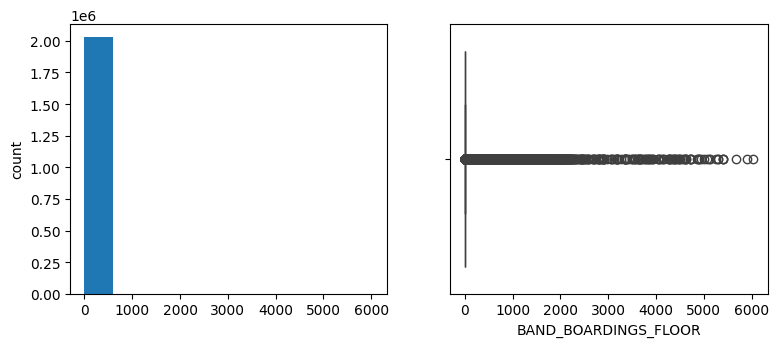

In [9]:
for col in num_cols:
	print(col)
	print('Skew :', round(df[col].skew(), 2))
	plt.figure(figsize = (9, 3.5))
	plt.subplot(1, 2, 1)
	df[col].hist(grid=False)
	plt.ylabel('count')
	plt.subplot(1, 2, 2)
	sns.boxplot(x=df[col])
	plt.show()

Categorical Variables:
Index(['ROUTE_CODE', 'GTFS_ID', 'MEDIUM_TYPE_LABEL',
       'NUM_MODE_TRANSPORT_LABEL', 'ROUTE_DIRECTION_LABEL', 'MONTH', 'WEEK',
       'DAY_OF_WEEK', 'YEAR_WEEK'],
      dtype='object')


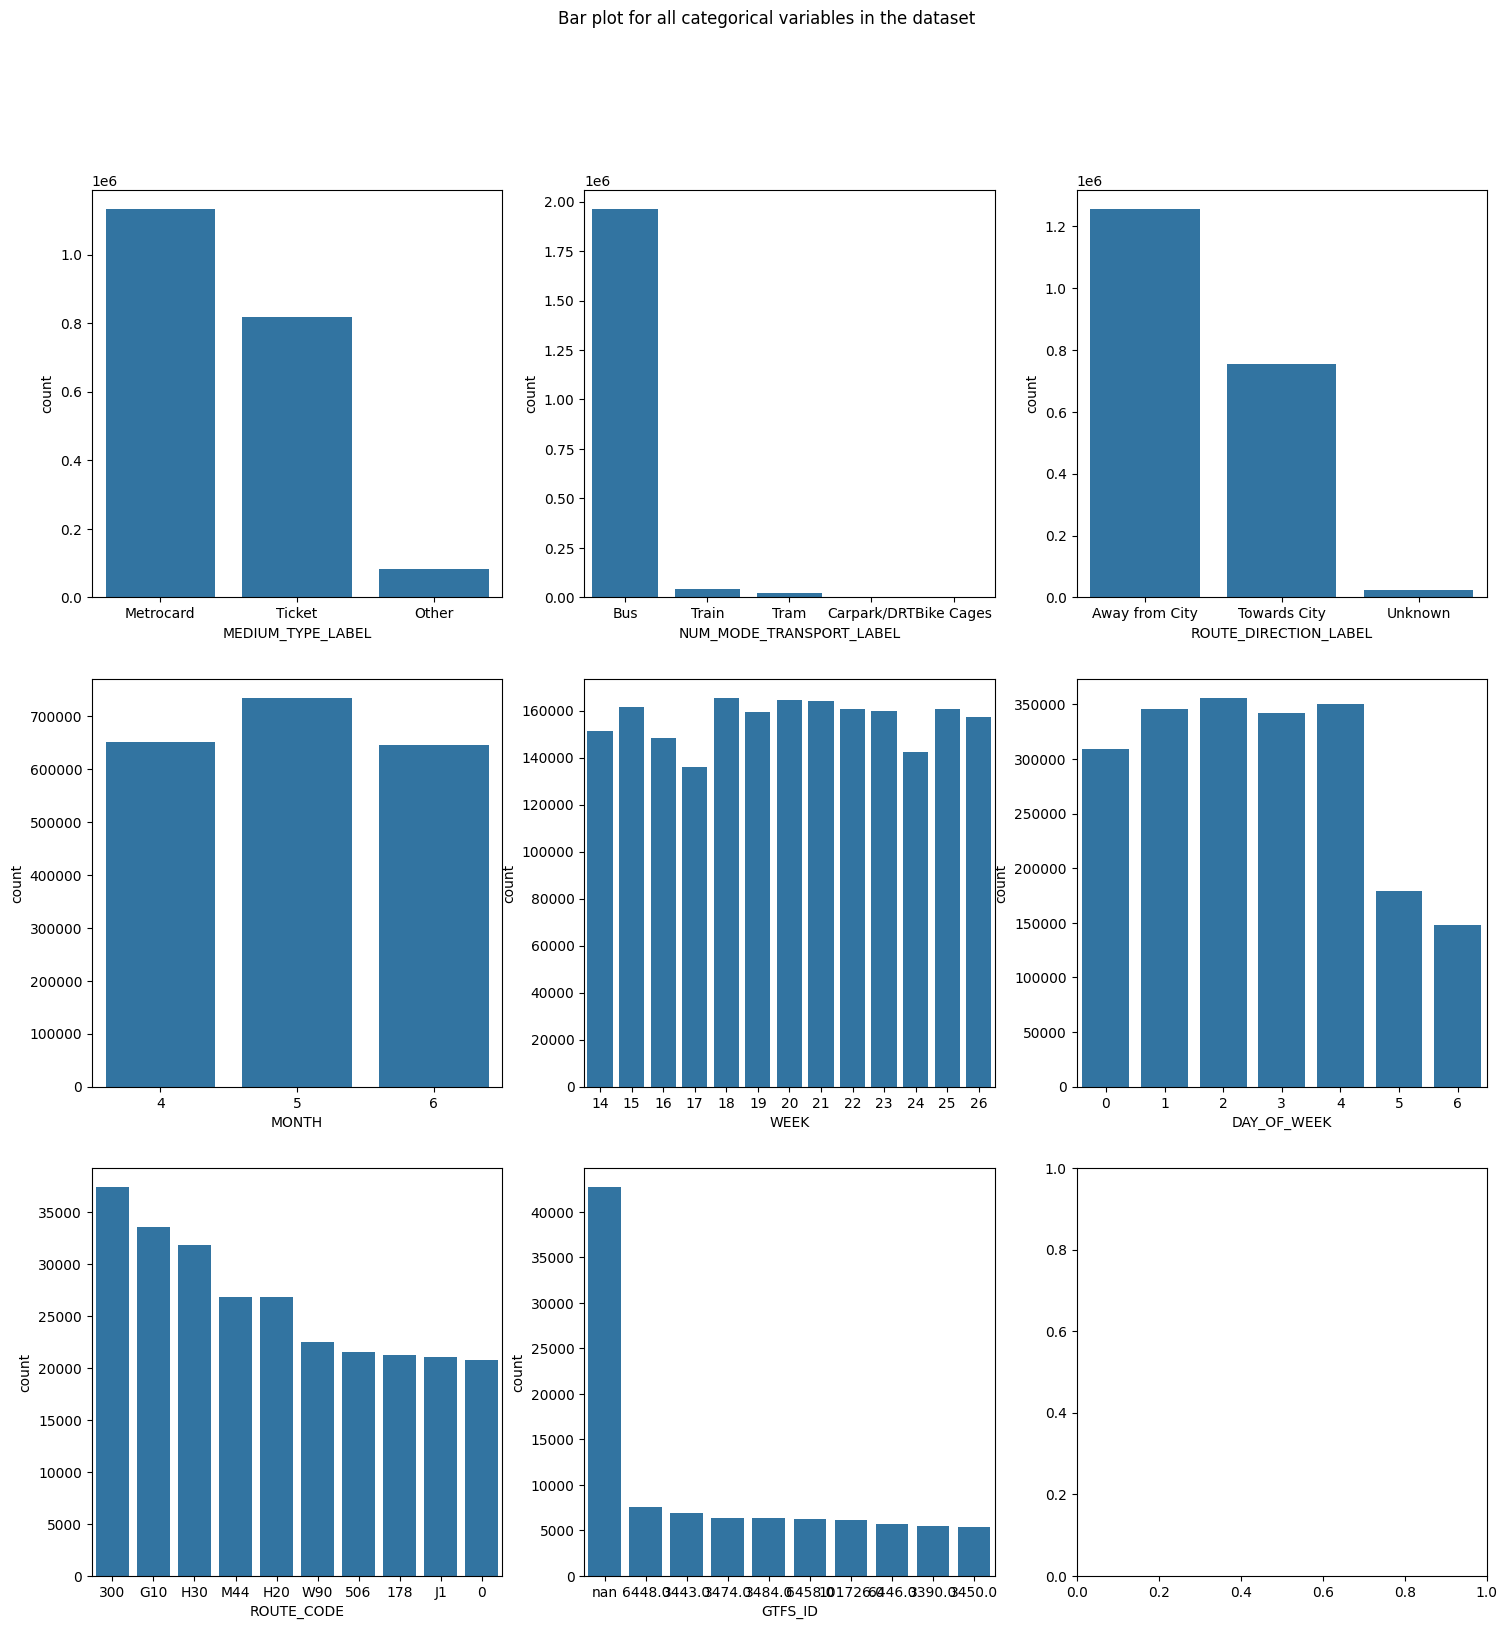

In [10]:
print("Categorical Variables:")
print(cat_cols)
fig, axes = plt.subplots(3, 3, figsize = (18, 18))
fig.suptitle('Bar plot for all categorical variables in the dataset')
# general information
sns.countplot(ax = axes[0, 0], x = 'MEDIUM_TYPE_LABEL', data = df, 
              order = df['MEDIUM_TYPE_LABEL'].value_counts().index);
sns.countplot(ax = axes[0, 1], x = 'NUM_MODE_TRANSPORT_LABEL', data = df, 
              order = df['NUM_MODE_TRANSPORT_LABEL'].value_counts().index);
sns.countplot(ax = axes[0, 2], x = 'ROUTE_DIRECTION_LABEL', data = df, 
              order = df['ROUTE_DIRECTION_LABEL'].value_counts().index);
# time related
sns.countplot(ax = axes[1, 0], x = 'MONTH', data = df);
sns.countplot(ax = axes[1, 1], x = 'WEEK', data = df);
sns.countplot(ax = axes[1, 2], x = 'DAY_OF_WEEK', data = df);

# Top specific information
sns.countplot(ax = axes[2, 0], x = 'ROUTE_CODE', data = df, 
              order = df['ROUTE_CODE'].value_counts().iloc[:10].index);
sns.countplot(ax = axes[2, 1], x = 'GTFS_ID', data = df, 
              order = df['GTFS_ID'].value_counts().iloc[:10].index);

# axes[1][1].tick_params(labelrotation=45);
# axes[2][0].tick_params(labelrotation=90);
# axes[2][1].tick_params(labelrotation=90);